In [1]:
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR, SVC
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import seaborn as sns
import sklearn.model_selection
import statsmodels.api as sm
import ta
%matplotlib inline
p = "PuRd"
plt.style.use('default')

# Task 1

(3073, 7)
               open         close        volume          high           low  \
count   3073.000000   3073.000000  3.073000e+03   3073.000000   3073.000000   
mean   11300.065097  11308.630346  1.395598e+10  11595.863515  10972.396817   
std    16243.433760  16242.872749  1.954176e+10  16665.300947  15758.625212   
min      176.897003    178.102997  2.857830e+06    211.731003    171.509995   
25%      581.650024    581.645020  5.780140e+07    589.151001    571.814026   
50%     5271.746394   5279.348211  4.390020e+09   5363.257523   5169.283391   
75%    10588.184021  10594.493354  2.432216e+10  10847.256993  10291.694493   
max    67549.735581  67566.830088  3.509679e+11  68789.625939  66382.061008   

         market_cap  
count  3.073000e+03  
mean   2.080593e+11  
std    3.066943e+11  
min    2.444379e+09  
25%    7.737830e+09  
50%    9.321830e+10  
75%    1.893255e+11  
max    1.274831e+12  


/var/folders/8h/0y2pf_1n2735m_vsyhnb7lkw0000gn/T/ipykernel_2380/2321548386.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(btc.corr(), cmap=p)


<AxesSubplot: >

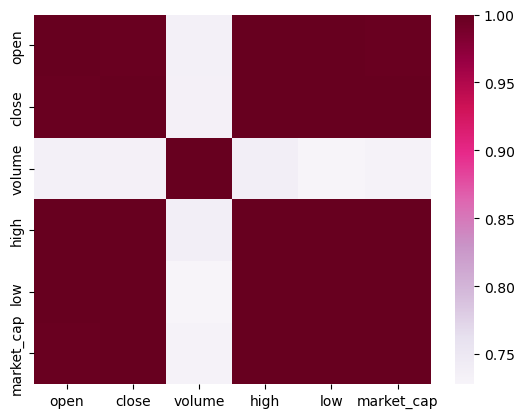

In [2]:
# Import the Data
btc = pd.read_csv("btchistorical.csv", parse_dates=["date"])
btc.columns = [c.replace(' ', '_') for c in btc.columns]
print(btc.shape)
# Summary statistics
desc = btc.describe()
print(desc)
sns.heatmap(btc.corr(), cmap=p)

# Task 2
Construct the following ten predictors/factors based on the provided formulas. Where you need to
calculate a factor that needs price, use the closing price.

<AxesSubplot: >

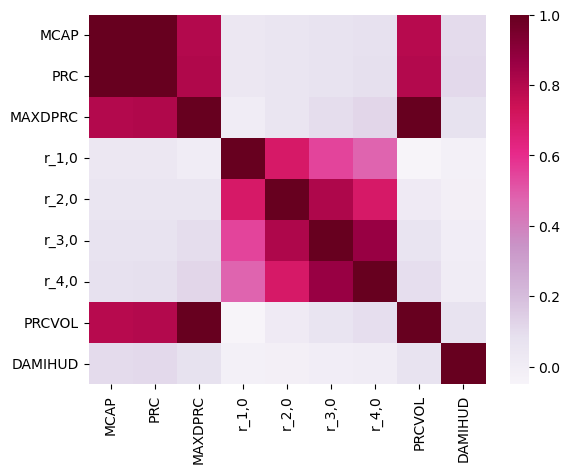

In [3]:
btc["MCAP"] = np.log(btc.market_cap)
btc["PRC"] = np.log(btc.close)
btc["MAXDPRC"] = btc.close.rolling(7).apply(lambda x: np.max(x))
# Momentum
for i in range(1,5):
    btc[f"r_{i},0"] = btc.close.rolling(i*7).apply(lambda x: x.iloc[-1]-x.iloc[0])
# TODO Past one-to-four-week return
#btc["r_4,1"] = np.NAN
# ?same value for all datapoints. Should this be done using a rolling mehtod?
btc["PRCVOL"] = list(map(lambda x: np.log(np.average(x.volume)) * x.close.iloc[0], btc.rolling(7)))
btc["STDPRCVOL"] = np.log(np.std(btc.PRCVOL))
btc["DAMIHUD"] = btc.close.rolling(2).apply(lambda x: np.abs((x.iloc[-1]-x.iloc[0])/(x.iloc[0])))
sns.heatmap(btc[['MCAP', 'PRC', 'MAXDPRC', 'r_1,0', 'r_2,0', 'r_3,0', 'r_4,0', 'PRCVOL', 'DAMIHUD']].corr(), cmap=p)

# Task 3
Calculate seven day return based on the closing price using the following formula

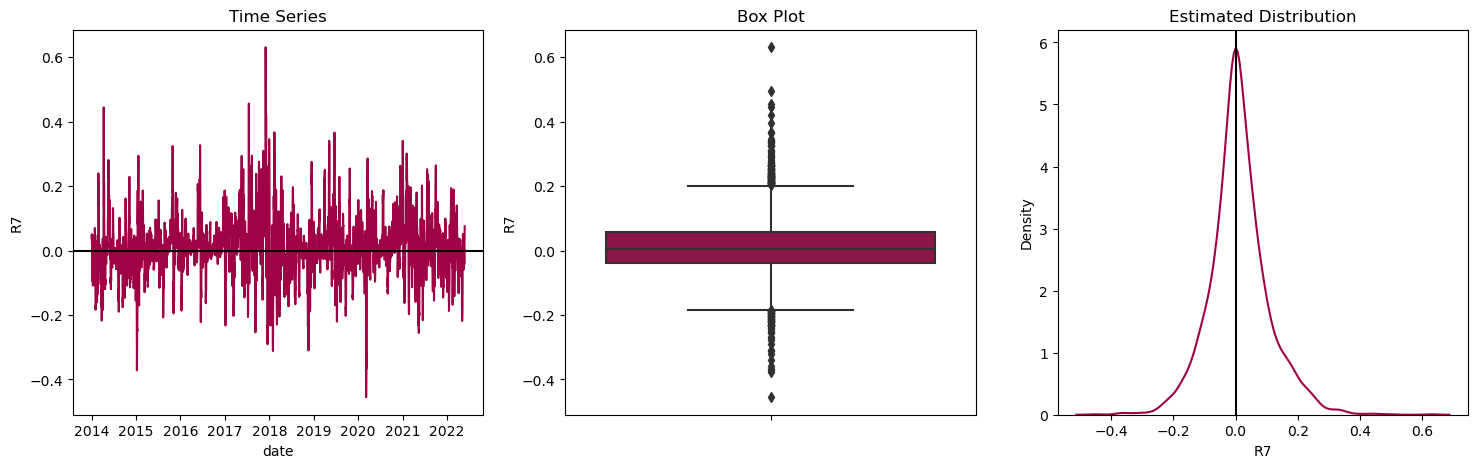

In [4]:
# Create 7 day return
days=7
btc["R7"] = btc.close.rolling(days).apply(lambda x: (x.iloc[-1]-x.iloc[0])/(x.iloc[0]))
btc.R7= btc.R7.shift(-days+1)

# Plot
c = sns.color_palette(p)[5]
fig, ax = plt.subplots(figsize=(18, 5), nrows=1, ncols=3)
 # Plot time series as a line graph
sns.lineplot(x=btc.date, y=btc.R7, color=c, ax=ax[0])
ax[0].axhline(color="black")
ax[0].set_title('Time Series')

# Plot time series as a box plot
sns.boxplot(y=btc.R7, color=c, ax=ax[1])
ax[1].set_title('Box Plot')

sns.kdeplot(x=btc.R7, color=c, ax=ax[2])
ax[2].axvline(color="black")
ax[2].set_title('Estimated Distribution')
# Show the plot
plt.show()

In [5]:
# Add 1-7 day lagged prices
for i in range(1,8):
    btc[f"close_lagged_{i}"] = btc.close.shift(periods=i)

In [6]:
# More Predictors (these will be used in Task7 to improve the trading strategy)
btc['SMA_7'] = btc['close'].rolling(window=7).mean()  # Simple Moving Average
btc['SMA_21'] = btc['close'].rolling(window=21).mean()
btc['SMA_50'] = btc['close'].rolling(window=50).mean()
btc['STD_7'] = btc['close'].rolling(window=7).std()   # Standard Deviation
btc['STD_21'] = btc['close'].rolling(window=21).std()
btc['STD_50'] = btc['close'].rolling(window=50).std()
btc['RSI'] = ta.momentum.RSIIndicator(btc['close'], window=14).rsi()
btc['MACD'] = ta.trend.MACD(btc['close']).macd()

# Create lag features
for i in range(1, 8):
    btc['Close_Lag_'+str(i)] = btc['close'].shift(i)
    btc['Volume_Lag_'+str(i)] = btc['volume'].shift(i)
    btc['SMA_7_Lag_'+str(i)] = btc['SMA_7'].shift(i)
    btc['SMA_21_Lag_'+str(i)] = btc['SMA_21'].shift(i)
    btc['SMA_50_Lag_'+str(i)] = btc['SMA_50'].shift(i)
    btc['STD_7_Lag_'+str(i)] = btc['STD_7'].shift(i)
    btc['STD_21_Lag_'+str(i)] = btc['STD_21'].shift(i)
    btc['STD_50_Lag_'+str(i)] = btc['STD_50'].shift(i)
    btc['RSI_Lag_'+str(i)] = btc['RSI'].shift(i)
    btc['MACD_Lag_'+str(i)] = btc['MACD'].shift(i)

In [7]:
# Drop all rows with NaN
btc = btc.dropna()

# Task 4
Divide historical prices and volume (i.e., open, close, high, low, and volume) into training, validation, and testing samples and use linear regression, random forest, and support vector machine to investigate the performance of past prices for return prediction.

In [8]:
X = btc[["open", "close", "high", "low", "volume"]]
y = btc.R7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [9]:
def eval(y_true_oos, y_pred_oos, y_true_ins, y_pred_ins, name):
    print(f"{name} out of Sample MSE: {mean_squared_error(y_pred=y_pred_oos, y_true=y_true_oos)}")
    print(f"{name} out of Sample R2: {r2_score(y_pred=y_pred_oos, y_true=y_true_oos)}")
    print(f"{name} in Sample MSE: {mean_squared_error(y_pred=y_pred_ins, y_true=y_true_ins)}")
    print(f"{name} in Sample R2: {r2_score(y_pred=y_pred_ins, y_true=y_true_ins)}")

## 📈Simple Linear Model

In [10]:
def stepwise_selection(X, y, initial_list=[], threshold_in=0.01, threshold_out = 0.05, verbose=True):
    included = list(initial_list)
    while True:
        changed = False
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype='float64')
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(X[included+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature_pos = new_pval.argmin()
            best_feature = excluded[best_feature_pos]
            included.append(best_feature)
            changed = True
            if verbose:
                print(f'Add {best_feature} with p-value {best_pval}')
        # backward step
        model = sm.OLS(y, sm.add_constant(X[included])).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed = True
            worst_feature_pos = pvalues.argmax()
            worst_feature = excluded[worst_feature_pos]
            included.remove(worst_feature)
            if verbose:
                print(f'Drop {worst_feature} with p-value {worst_pval}')
        if not changed:
            break
    return model, included

In [11]:
linear_model, features = stepwise_selection(X=X_train, y=y_train)
y_pred_oos = linear_model.predict(sm.add_constant(X_test[features]))
y_pred_ins = linear_model.predict(sm.add_constant(X_train[features]))
eval(y_true_oos=y_test, y_pred_oos=y_pred_oos, y_pred_ins=y_pred_ins, y_true_ins=y_train, name="Simple Linear Model")

Add low with p-value 0.008171833621144452
Simple Linear Model out of Sample MSE: 0.010397411577704801
Simple Linear Model out of Sample R2: -0.18428824385437892
Simple Linear Model in Sample MSE: 0.009303061377579452
Simple Linear Model in Sample R2: 0.003318512712377819


## 🌲Simple Random Forest

In [12]:
# Create Random Forest Classifier model
rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor())
])


# Define hyperparameters to search over
param_grid = {
    'rf__n_estimators': [50, 100, 150, 200],
    'rf__max_depth': [5, 10, 15, 20],
    'rf__min_samples_split': [2, 4, 6],
    'rf__min_samples_leaf': [1, 2, 4]
}

# Use GridSearchCV to find best hyperparameters
grid_search_rf = GridSearchCV(rf, param_grid=param_grid, cv=10, n_jobs=-1, verbose=1)

# Create Random Forest Classifier model with best hyperparameters
grid_search_rf.fit(X=X_train, y=y_train)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [5, 10, 15, 20],
                         'rf__min_samples_leaf': [1, 2, 4],
                         'rf__min_samples_split': [2, 4, 6],
                         'rf__n_estimators': [50, 100, 150, 200]},
             verbose=1)

In [13]:
y_rf_oos = grid_search_rf.best_estimator_.predict(X_test)
y_rf_ins = grid_search_rf.best_estimator_.predict(X_train)
eval(y_true_oos=y_test,
     y_pred_oos=y_rf_oos,
     y_pred_ins=y_rf_ins,
     y_true_ins=y_train,
     name="Simple Random Forest")

Simple Random Forest out of Sample MSE: 0.041434448349304674
Simple Random Forest out of Sample R2: -3.719475583316779
Simple Random Forest in Sample MSE: 0.007624711391691035
Simple Random Forest in Sample R2: 0.18312817882463817


## 🏹Simple Support Vector Regression

In [14]:
# SVM
svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVR())
])

# Define the grid of hyperparameters to search over
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf', 'poly'],
    'svc__degree': [2, 3, 4],
    'svc__gamma':['scale', 'auto']
}

# Perform grid search using 10-fold cross-validation
grid_search_svm = GridSearchCV(svm, param_grid, cv=10, n_jobs=-1, verbose=1)

# Fit the grid search to the data
grid_search_svm.fit(X_train, y_train)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc', SVR())]),
             n_jobs=-1,
             param_grid={'svc__C': [0.1, 1, 10], 'svc__degree': [2, 3, 4],
                         'svc__gamma': ['scale', 'auto'],
                         'svc__kernel': ['linear', 'rbf', 'poly']},
             verbose=1)

In [15]:
# Evaluate the best model on the test set
y_svm_oos = grid_search_svm.best_estimator_.predict(X_test)
y_svm_ins = grid_search_svm.best_estimator_.predict(X_train)
eval(y_true_oos=y_test,
     y_pred_oos=y_svm_oos,
     y_pred_ins=y_svm_ins,
     y_true_ins=y_train,
     name="Simple Random Forest")

Simple Random Forest out of Sample MSE: 0.01941154323463901
Simple Random Forest out of Sample R2: -1.2110178361265476
Simple Random Forest in Sample MSE: 0.009309585107157766
Simple Random Forest in Sample R2: 0.002619594341867426


# Task 5
Divide factors’ data into training, validation, and testing samples and use the machine learning
techniques from the last step to evaluate the performance of these factors for return prediction.

In [16]:
X = btc[['open', 'close', 'high', 'low', 'volume', 'MCAP', 'PRC', 'MAXDPRC', 'r_1,0', 'r_2,0', 'r_3,0', 'r_4,0', 'PRCVOL', 'DAMIHUD']]
y = btc.R7
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3, shuffle=False)

## 📈Linear Regression

In [17]:
linear_model, features = stepwise_selection(X=X_train, y=y_train)
y_pred_oos = linear_model.predict(sm.add_constant(X_test[features]))
y_pred_ins = linear_model.predict(sm.add_constant(X_train[features]))
eval(y_true_oos=y_test, y_pred_oos=y_pred_oos, y_pred_ins=y_pred_ins, y_true_ins=y_train, name="Simple Linear Model")

Add r_3,0 with p-value 0.001948100024801339
Add PRCVOL with p-value 0.0008654362628850519
Add MCAP with p-value 2.3461037254106144e-12
Add PRC with p-value 0.0005200302674277122
Add DAMIHUD with p-value 0.000499777599943653
Add r_2,0 with p-value 0.0011543954864985917
Add MAXDPRC with p-value 0.009256873122546163
Simple Linear Model out of Sample MSE: 0.08041000673503498
Simple Linear Model out of Sample R2: -8.158878145090684
Simple Linear Model in Sample MSE: 0.008852399615818629
Simple Linear Model in Sample R2: 0.05160006399375883


## 🌲Random Forest

In [18]:
grid_search_rf.fit(X=X_train, y=y_train)

y_svm_oos = grid_search_rf.best_estimator_.predict(X_test)
y_svm_ins = grid_search_rf.best_estimator_.predict(X_train)
eval(y_true_oos=y_test,
     y_pred_oos=y_svm_oos,
     y_pred_ins=y_svm_ins,
     y_true_ins=y_train,
     name="Random Forest")

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Random Forest out of Sample MSE: 0.02296337055412687
Random Forest out of Sample R2: -1.6155788470314203
Random Forest in Sample MSE: 0.007062626729652575
Random Forest in Sample R2: 0.24334699865229104


[Text(0.5, 1.0, 'Variable Importance')]

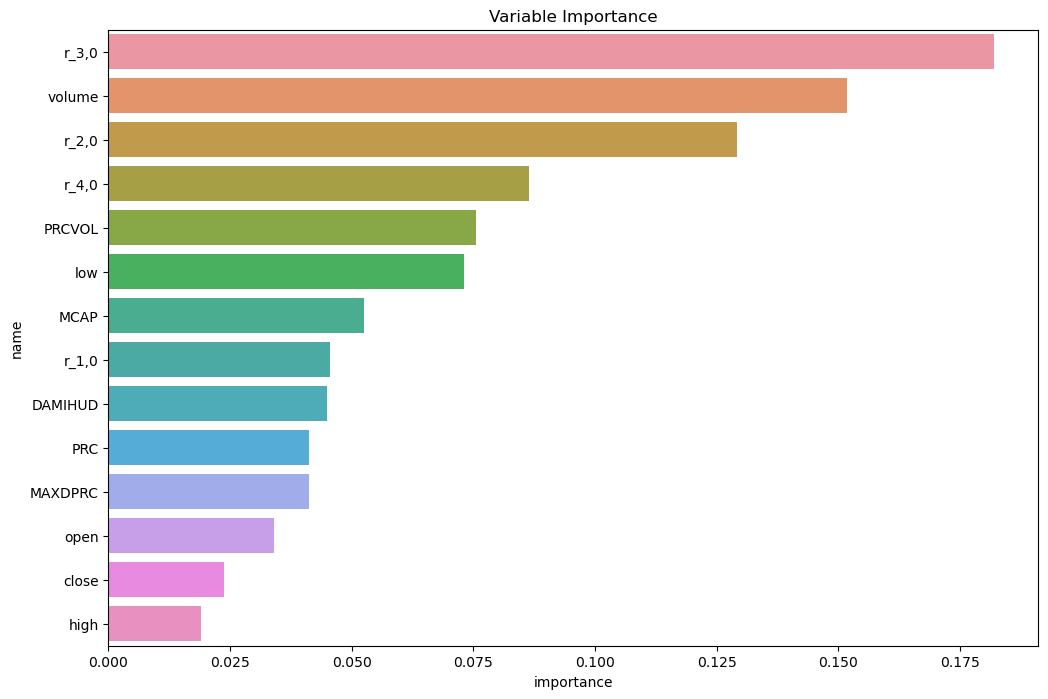

In [19]:
pred_vars = grid_search_rf.best_estimator_.feature_names_in_
imp = grid_search_rf.best_estimator_.named_steps["rf"].feature_importances_
imp = pd.DataFrame({"importance":imp, "name": pred_vars})
imp = imp.sort_values(by=["importance"], ascending=False)

fig, ax = plt.subplots(figsize=(12, 8), nrows=1, ncols=1)
sns.barplot(x=imp.importance,y=imp.name, ax=ax).set(title='Variable Importance')

## 🏹SVM

In [20]:
grid_search_svm.fit(X=X_train, y=y_train)

y_svm_oos = grid_search_svm.best_estimator_.predict(X_test)
y_svm_ins = grid_search_svm.best_estimator_.predict(X_train)
eval(y_true_oos=y_test,
     y_pred_oos=y_svm_oos,
     y_pred_ins=y_svm_ins,
     y_true_ins=y_train,
     name="SVM")

Fitting 10 folds for each of 54 candidates, totalling 540 fits
SVM out of Sample MSE: 0.16861946000113143
SVM out of Sample R2: -18.20613055201336
SVM in Sample MSE: 0.008885851801756179
SVM in Sample R2: 0.04801617122125568


# Task 7
Consider an initial investment of $100,000€$ and the following trading strategy:  
-   First, a negative development forecast of the Bitcoin price is interpreted as a sell signal. Accordingly, a forecast of increasing Bitcoin prices indicates a reasonable moment for buying additional Bitcoins if the overall budget allows the additional investment. 
-   Second, at the beginning of the trading period, the complete budget is invested in Bitcoins with a price of $p_0$.
-   Third, if the entire budget is invested, the strategy does not imply actions during a subsequent predicted increase for the Bitcoin price.
-   Fourth, if the forecasting model predicts decreasing prices, Bitcoins are sold at the current price $p_t$.
-   Fifth, when Bitcoin prices are predicted to rise again, the strategy suggests investing the completeavailable budget on Bitcoins at the current price $p_{t+k}$. 

In this setting, we consider Bitcoin trading costs to be negligible. 

Use out-of-sample return predictions between 31.05.21-31.05.2022 from steps four and five for trading. 

Compare your results with a buy-and-hold strategy (i.e., Bitcoin is purchased at time $0$ for a price of $p_0$ and sold at the end of the period $t = 1, ..., T$ for a price of $p_T$ ).

In [21]:
# Training Data
Train = btc.loc[btc.date <= datetime(2021, 5, 1,0,0,0,0, pytz.UTC),]
Test = btc.loc[btc.date > datetime(2021, 5, 1,0,0,0,0, pytz.UTC),]
# ! different Time Zones
Test = Test.loc[Test.date <= datetime(2022, 5, 2,0,0,0,0, pytz.UTC),]
# Define features and target variable
X = Train.drop('R7', axis=1).drop('date', axis=1)
y = Train.R7
y_class = [r>0 for r in y]
X_test = Test.drop('R7', axis=1).drop('date', axis=1)
y_test = Test.R7
y_class_test = [r>0 for r in y_test]

## 🌲Random Forest Classifier

In [22]:
# Create Random Forest Classifier model
rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())
])


# Define hyperparameters to search over
param_grid = {
    'rf__n_estimators': [50, 100, 150, 200],
    'rf__max_depth': [5, 10, 15, 20],
    'rf__min_samples_split': [2, 4, 6],
    'rf__min_samples_leaf': [1, 2, 4]
}

# Use GridSearchCV to find best hyperparameters
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X=X,y=y_class)

# Create Random Forest Classifier model with best hyperparameters
y_pred_rfc = grid_search.best_estimator_.predict(X_test)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


## 🌲Random Forest Regressor

In [23]:
# Create Random Forest Classifier model
rf = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(-1,1))),
    ('rf', RandomForestRegressor())
])


# Define hyperparameters to search over
param_grid = {
    'rf__n_estimators': [50, 100, 150, 200],
    'rf__max_depth': [5, 10, 15, 20],
    'rf__min_samples_split': [2, 4, 6],
    'rf__min_samples_leaf': [1, 2, 4]
}

# Use GridSearchCV to find best hyperparameters
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X=X,y=y)

# Create Random Forest Classifier model with best hyperparameters
y_pred_rfr = grid_search.best_estimator_.predict(X_test)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


## 🏹Support Vector Regressor

In [24]:
svm = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(-1,1))),
    ('svc', SVR())
])

# Define the grid of hyperparameters to search over
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf', 'poly'],
    'svc__degree': [2, 3, 4],
    'svc__gamma':['scale', 'auto']
}

# Perform grid search using 10-fold cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X=X,y=y)

# Evaluate the best model on the test set
y_pred_svr = grid_search.best_estimator_.predict(X_test)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


## 🏹Support Vector Classifier

In [25]:
svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

# Define the grid of hyperparameters to search over
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf', 'poly'],
    'svc__degree': [2, 3, 4],
    'svc__gamma':['scale', 'auto']
}

# Perform grid search using 10-fold cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X=X,y=y_class)

# Evaluate the best model on the test set
y_pred_svc = grid_search.best_estimator_.predict(X_test)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


## 💰Evaluation

In [26]:
def calc_ts(signals:list, name:str, verbose:bool=True):
    # Starting Capital
    m = 10_000
    coins = 0
    capital_ts = list()
    
    for i, signal in enumerate(signals):
        price = Test.iloc[i].close
        if signal and m:
            # Buy
            coins = m/price
            m = 0
            if verbose: print(f"[INFO] {name} Bought {coins} BTC at {price}")
        elif not signal and coins:
            # Sell
            m = coins * price
            if verbose: print(f"[INFO] {name} Sold {coins} BTC at {price}")
            coins = 0
        # Append current net worth
        capital_ts.append(m + coins*price)
    # Sell after last period
    if coins:
        price = Test.iloc[i].close
        m = coins * price
        if verbose: print(f"[INFO] {name} Sold {coins} BTC at {price}")
        coins = 0
    print(f"[INFO] {name}: Total Capital {m}")
    #sns.lineplot(capital_ts, label=name)
    #plt.plot(capital_ts, label=name)
    return capital_ts, m

[INFO] SVC: Total Capital 6652.324171741787
[INFO] SVR: Total Capital 7195.777149370133
[INFO] RFC: Total Capital 6976.666056063549
[INFO] RFR: Total Capital 7745.926487515778
[INFO] Buy & Hold: Total Capital 6652.324171741787


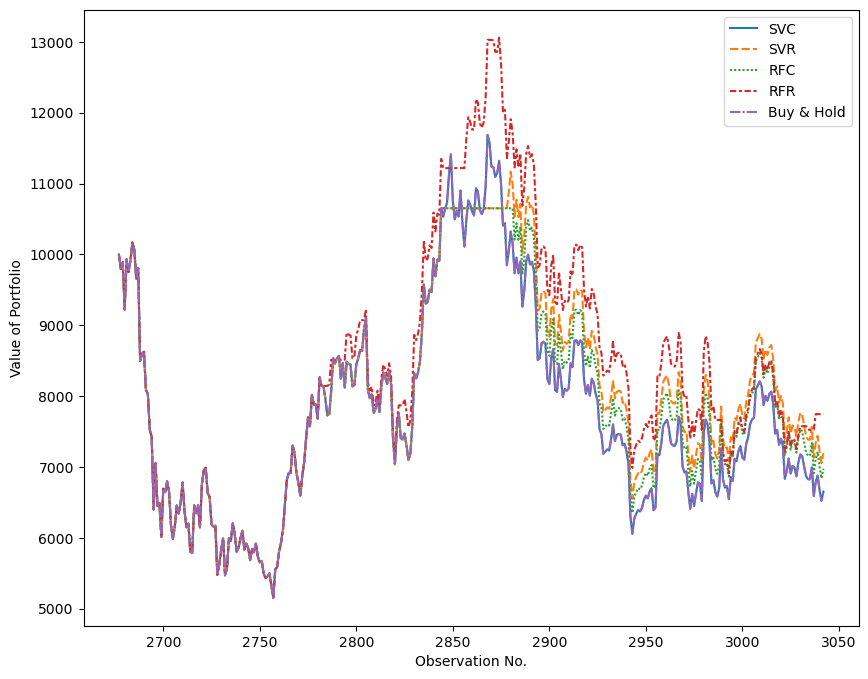

In [64]:
fig, ax = plt.subplots(figsize=(10, 8), nrows=1, ncols=1)

svc_ts, _ = calc_ts(signals=y_pred_svc, name="SVC", verbose=False)
svr_ts, _ = calc_ts(signals=[s>0 for s in y_pred_svr], name="SVR", verbose=False)
rfc_ts, _ = calc_ts(signals=y_pred_rfc, name="RFC", verbose=False)
rfr_ts, _ = calc_ts(signals=[s>0 for s in y_pred_rfr], name="RFR", verbose=False)
bnh_ts, _ = calc_ts(signals=[True]*366, name="Buy & Hold", verbose=False)

data = pd.DataFrame({
    'Date': Test.date, 
    'SVC': svc_ts,
    'SVR': svr_ts,
    'RFC': rfc_ts,
    'RFR': rfr_ts,
    'Buy & Hold': bnh_ts})
ax = sns.lineplot(data=data)
ax.set_xlabel('Observation No.')
ax.set_ylabel('Value of Portfolio')
plt.legend(prop={'size': 10})